# Contact Graph Generator

In [13]:
import logging
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.algorithms.search_algorithm import ReexploreLevel
from large_gcs.algorithms.gcs_astar import GcsAstar
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_under,
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.contact.contact_regions_set import ContactRegionParams

import numpy as np
from copy import deepcopy
from IPython.display import HTML


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
# logging.getLogger("large_gcs").setLevel(logging.INFO)
logging.getLogger("drake").setLevel(logging.WARNING)

## Simple Demo 2

In [ ]:
ws = 3
params = ContactGraphGeneratorParams(
    name="cg_simple_2",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_obj_pos=[[2, 0]],
    target_rob_pos=[[2.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

In [ ]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.FULL,
)
sol = gcs_astar.run()

In [ ]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_under)
gcs_astar = GcsAstar(
    cg,
    cost_estimator=cost_estimator,
    use_convex_relaxation=False,
)
sol = gcs_astar.run()

In [ ]:
sol = cg.solve_shortest_path(use_convex_relaxation=False)
print(sol)

In [ ]:
sol = cg.solve_shortest_path(use_convex_relaxation=True)
print(sol)

## Simple Demo 3 (Target Region)

In [ ]:
ws = 3
target_regions = [
    ContactRegionParams(region_vertices=[[1.5,-1], [1.5,1], [3,1], [3,-1]],
                  obj_indices=[0]),
]

params = ContactGraphGeneratorParams(
    name="cg_simple_3",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Triangle Challenge 2

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01


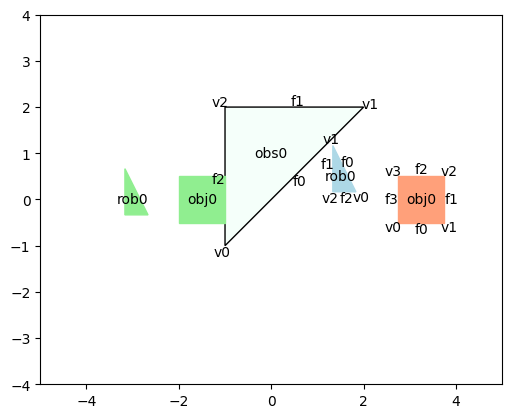

In [2]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal2",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[-3, 0]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [3]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 79.06it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:00<00:00, 518.59it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3177.19it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 9187.79it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 9577.97it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 16290/16290 [00:02<00:00, 6884.88it/s]
INFO:large_gcs.graph.contact_graph:6120 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 6709.91it/s]
INFO:large_gcs.graph.contact_graph:Creatin

In [4]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 61.30it/s]
INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:00<00:00, 529.85it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 8810.13it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 11835.39it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 8050.94it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 5666.06it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 4531.26it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_verti

In [16]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 42799.02it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 10192.72it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 64.26it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 4407.37it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 30727.50it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 8019.70it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 79.25it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 14347.19it/s]


Just checking that everything works

In [15]:
logging.getLogger("large_gcs.algorithms.gcs_astar_convex_restriction").setLevel(logging.DEBUG)
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'source', 'target'}
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.011, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 1 neighbors (0)
DEBUG:large_gcs.algorithms.gcs_astar_convex_restriction:edge source -> ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0') is feasible, new dist: 238.26001654659783, added to pq True
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'source', "('NC|obs0_f0-obj0_v3',

In [ ]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

In [ ]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal3",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[-3, 0]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[1.5, 0.5]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Triangle Challenge 4 (Target Region)

In [ ]:
ws_x = 5
ws_y = 4
target_region_params = [
    ContactRegionParams(region_vertices=[[-3,-0.75], [-3,1], [-1,-0.75], [-1,1]],
                  obj_indices=[0]),
]
params = ContactGraphGeneratorParams(
    name="cg_trichal4",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Maze a1

In [ ]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a1",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.6]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Maze a2

In [ ]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a2",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## StackPush

In [ ]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(region_vertices=[[3,0], [3,-3], [6,0], [6,-3]],
                  obj_indices=[0, 1]),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a1",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2] ]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
                  [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

In [ ]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(region_vertices=[[3,0], [3,-3], [6,0], [6,-3]],
                  obj_indices=[0,1,2]),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2] ]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
                  [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
                  [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1], [0.4, 1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)